## Predict the next-day Bitcoin price. 

Firstly we have done an EDA in order to prepare the data for later use in prediction algorithms. For which, we developed a prediction model based on LSTM.

We start importing the necesary libraries for this project. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# 1. Data preparation

Use YFinance for the bitcoin market. We get the following columns:

    *Date*
    *Open*. The opening price of that day. (the first price of the day)
    *High* The highest price of that day.
    *Low* The lowest price of that day.
    *Close* The closing price of the day (That day’s last price)
    *Volume* The amount of Bitcoin traded on that day.

    

In [2]:
# Open
bitcoin = yf.Ticker("BTC-USD")

# Get historical market data
bit_hist = bitcoin.history(period="max")
# Drop the columns that are not needed
bit_hist.drop(columns=['Dividends','Stock Splits'],inplace=True)
# Rename the columns
bit_hist.rename(columns={'Open': 'Bitcoin_Open', 'High': 'Bitcoin_High', 'Low': 'Bitcoin_Low', 'Close': 'Bitcoin_Close', 'Volume': 'Bitcoin_Volume'}, inplace=True)
bit_hist.reset_index(inplace=True)
bit_hist['Date'] = bit_hist['Date'].dt.strftime('%d/%m/%y')
bit_hist

,Date,Bitcoin_Open,Bitcoin_High,Bitcoin_Low,Bitcoin_Close,Bitcoin_Volume
0,17/09/14,465.864014,468.174011,452.421997,457.334015,21056800
1,18/09/14,456.859985,456.859985,413.104004,424.440002,34483200
2,19/09/14,424.102997,427.834991,384.532013,394.795990,37919700
3,20/09/14,394.673004,423.295990,389.882996,408.903992,36863600
4,21/09/14,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...,...
3530,17/05/24,65231.296875,67459.460938,65119.316406,67051.875000,28031279310
3531,18/05/24,67066.210938,67387.328125,66663.500000,66940.804688,16712277406
3532,19/05/24,66937.929688,67694.296875,65937.179688,66278.367188,19249094538
3533,20/05/24,66278.742188,71483.562500,66086.171875,71448.195312,43850655717


# Deep Learning prediction

## LSTM model fitted by maximizing directional accuracy of the model

Pairplotting the variables for better understanding.

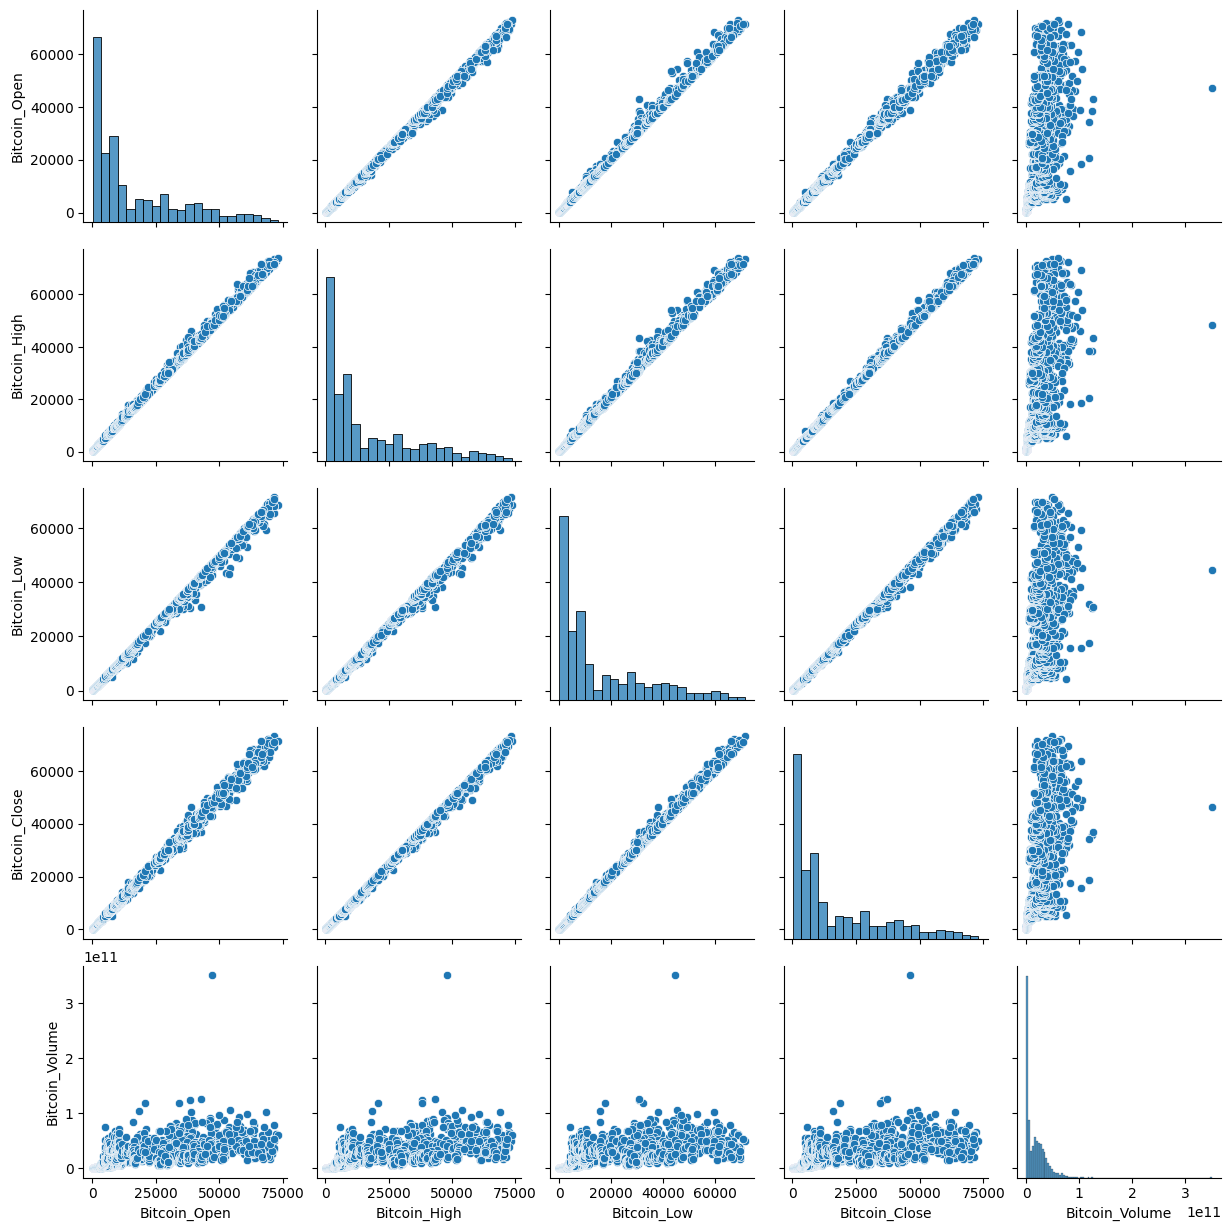

In [3]:
# Generating a pairplot to visualize relationships between variables in the bitcoin_cleaned dataset
sns.pairplot(bit_hist)
plt.show()

Using only the closing price simplifies the model, reduces complexity, and provides a stable reflection of market consensus. 

This approach helps avoid overfitting, ensures efficient training, and often suffices for trend analysis and prediction tasks.

In [4]:
# Creating the model_data with bitcoin close price
model_data = bit_hist['Bitcoin_Close']
model_data

0         457.334015
1         424.440002
2         394.795990
3         408.903992
4         398.821014
            ...     
3530    67051.875000
3531    66940.804688
3532    66278.367188
3533    71448.195312
3534    71046.664062
Name: Bitcoin_Close, Length: 3535, dtype: float64

In [5]:
# Split the model_data into training and testing sets
split_index = int(len(model_data) * 0.8)
train_data = model_data.iloc[:split_index]
test_data = model_data.iloc[split_index:]

In [6]:
# Scaling data using MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(pd.DataFrame(train_data))
scaled_test = scaler.transform(pd.DataFrame(test_data))

In [7]:
# Checking before and after scaling that we have the same amount of data
print(f'The lenght of the scaled train data is {len(scaled_train)} values')
print(f'The lenght of the unscaled train data is {len(train_data)} values')

The lenght of the scaled train data is 2828 values
The lenght of the unscaled train data is 2828 values


In [8]:
# Create look-back windows for the LSTM model
def create_lstm_data(data, look_back=60):
    
    # Creating the empty X,y lists
    X, y = [], []
    
    # Creating the look-back windows for the LSTM model
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 600
# Generating train and test final splits
X_train, y_train = create_lstm_data(scaled_train, look_back)
X_test, y_test = create_lstm_data(scaled_test, look_back)

In [9]:
X_train.shape

(2228, 600, 1)

### LSTM model configuration

- 4 layers: Different number of layers has been tried (2 to 6) and 4 layers was found the one with better results.
- 100 epochs: The ideal number of epochs to adjust to the model and avoid overfitting.
- Full batch size: Used specially in small datasets due to its computationally cost, it's found to be the most stable size in our case.
    - Size: Equal to the total number of training samples.
    - Pros: Utilizes the entire dataset to perform one update to the model weights, which can lead to stable, but slow, convergence.
    - Cons: Can be very computationally expensive and slow, especially with large datasets. It also requires significant memory, and sometimes it doesn't fit into GPU memory.
    - Typical Use: Small datasets or when the exact solution is very important.
- 600 days lookback: The ideal number of lookback days to obtain information while maintaining a significant test set size .
- adam optimizer: It was found to have better results than other optimizers like RMSprop or Adadelta.
- MSE metric: It was found to have better results than other metrics like MAE or MAPE.


In [10]:
# Initializing the model
regressor = Sequential()

# Add the first LSTM layer and apply Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Add the second LSTM layer and apply Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Add the third LSTM layer and apply Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Add the fourth LSTM layer and apply Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Add the output layer
regressor.add(Dense(units = 1))

# Compile the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Adjust the LSTM model to the training set
# regressor.fit(X_train, y_train, epochs = 100, batch_size = X_train.shape[0],callbacks=[early_stopping, lr_reduction])
regressor.fit(X_train, y_train, epochs = 100, batch_size = X_train.shape[0])

# Make predictions on the test data
predicted_prices = regressor.predict(X_test)

# Inverse transform of the data
predicted_prices_final = scaler.inverse_transform(predicted_prices)[:,0]
actual_prices_final = scaler.inverse_transform(y_test)[:,0]



Epoch 1/100


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0808
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0387
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0102
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0281
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0232
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0102
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0071
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0109
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0136
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0145
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0123
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0091
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0055
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0041
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0058
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.00

In [11]:
# Iterate through the layer list
layers_count = 0
for layer in regressor.layers:
    # Check if the layer is not of type "Dropout" or "Dense"
    if "Dropout" not in str(layer) and "Dense" not in str(layer):
       layers_count += 1
        # Count other unspecified layers
  
        

In [12]:
loss_metric = regressor.get_metrics_result()
loss_value = list(loss_metric.values())[0]

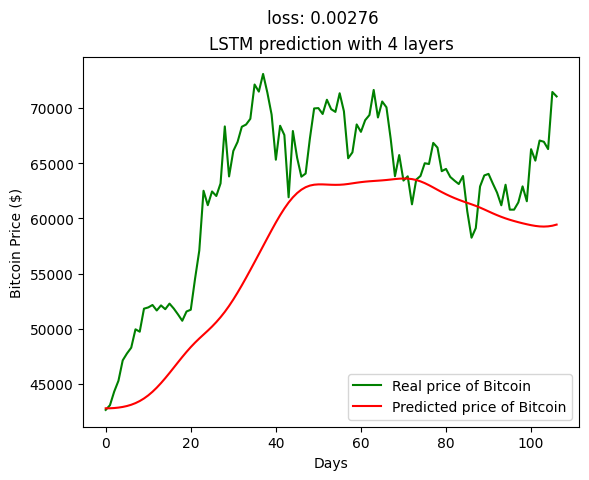

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 600, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 600, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 600, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 600, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 600, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 600, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,155 (832.64 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,104 (555.10 KB)

In [13]:
# Visualizing the results
plt.plot(actual_prices_final, color = 'green', label = 'Real price of Bitcoin')
plt.plot(predicted_prices_final, color = 'red', label = 'Predicted price of Bitcoin')
plt.title(f'LSTM prediction with {layers_count} layers')
plt.suptitle(f'loss: {round(loss_value, 6)}')
plt.xlabel('Days')
plt.ylabel('Bitcoin Price ($)')
plt.legend()
plt.show()
regressor.summary()

In [14]:
# Calculate the directional accuracy of the model by comparing the signs of actual and predicted price changes
actual_changes = np.diff(actual_prices_final)
predicted_changes = np.diff(predicted_prices_final)

actual_signs = np.sign(actual_changes)
predicted_signs = np.sign(predicted_changes)

# Compare signs and calculate accuracy 
correct_predictions = np.sum(actual_signs == predicted_signs)
total_predictions = len(predicted_signs)
directional_accuracy = (correct_predictions / total_predictions)*100
print(f'Directional Accuracy of the model: {directional_accuracy}%')

Directional Accuracy of the model: 57.54716981132076%


## LSTM Model General Metrics Remarks:
- The LSTM model with 4 layers exhibited an overall directional accuracy ranging from 46.10% to 58.25% across different trials.
- The model's performance varied based on the number of layers, epochs, and lookback periods, indicating sensitivity to these parameters.
- Directional accuracy improved with a longer lookback period, suggesting the importance of historical data in predicting Bitcoin prices.
- The model's accuracy was influenced by the complexity of the architecture and training parameters, highlighting the need for fine-tuning.

## LSTM Model Conclusion:
- The LSTM model demonstrated potential for predicting Bitcoin prices with directional accuracy up to 58.25%.
- Optimal performance was achieved with a 4-layer architecture, 100 epochs, and a 600-day lookback period.
- The model's ability to capture trends and patterns in Bitcoin prices indicates its suitability for forecasting in the cryptocurrency market.
- Continuous refinement and optimization of the LSTM model parameters can further enhance its predictive capabilities for future price movements.